In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import(
    train_test_split
)
from sklearn.datasets import(
    fetch_openml
)
import lightgbm as lgb


from mlarena import PreProcessor, ML_PIPELINE


# mlareana Advanced Usage

1. PreProcessing strategy analysis
2. Custom configure algorithms and preprocessing strategy
3. Baysian Hyperparameter tuning
4. Threshold analysis for classification models

# 1. PreProcessing Strategy Analysis

In [7]:
# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(100, 10, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features with low cardinality
    'education': np.random.choice(['High School', 'Bachelor', 'Master or above'], n_samples),
    'occupation': np.random.choice(['Engineer'], n_samples), #only one value
    
    # Categorical features with higher cardinality
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*80 + ['D']*30 + ['E']*20 + ['F']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

## Filter Feature Selection

Run filter feature selection based on 
1. missing threshold
2. mutual information threshold
3. feature with only one single value will also be excluded

In [8]:
fitler_fs = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  mi_threshold = 0.05)

Filter Feature Selection Summary:
Total features analyzed: 7

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Low mutual information (<0.05): 3 columns
   Columns: age, tenure, occupation

Recommended drops: (3 columns in total)


In [10]:
# detailed results available as a dataframe
fitler_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
0,city,0.0200,5,0.00625,object,0.016899,1.000000,False,False,False
1,product,0.0000,6,0.00750,object,0.011228,0.664413,False,False,False
2,income,0.0000,800,1.00000,float64,0.001354,0.080128,False,False,False
3,education,0.0275,3,0.00375,object,0.000904,0.053503,False,False,False
4,age,0.0475,762,0.95250,float64,0.000000,0.000000,False,False,True
5,tenure,0.0000,13,0.01625,int32,0.000000,0.000000,False,False,True
6,occupation,0.0000,1,0.00125,object,0.000000,0.000000,False,True,True


In [11]:
selected_cols = fitler_fs['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income, education


## Recommend encoding candidates

The `identify_encoding_candidates` method recommend encoding based on:

1. High cardinality threshold
2. Rare category
3. User preference

In [12]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train[selected_cols], high_cardinality_threshold=5)

-------------------------
Column `city` Analysis:
Recommend target encoding with higher smoothing due to moderate cardinality and rare category

column `city` details:
• Missing rate: 2.0%
• Unique values: 5
• Minimum category size: 24
• Rare categories: 2
-------------------------
Column `product` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `product` details:
• Missing rate: 0.0%
• Unique values: 6
• Minimum category size: 14
• Rare categories: 3
-------------------------
Column `education` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `education` details:
• Missing rate: 2.8%
• Unique values: 3
• Minimum category size: 247
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 3
• One-hot encoding cols: 0


In [13]:
# access the detailed analysis in dataframe form if preferred
encoding_recommendations['analysis']

,column,missing_rate,unique_values,min_category_size,rare_categories,encoding_note
0,city,0.0200,5,24,2,"Has 2 rare categories, careful for sparse feat..."
1,product,0.0000,6,14,3,Has 3 rare categories. Recommend higher smooth...
2,education,0.0275,3,247,0,Either encoding will do due to moderate cardin...


In [14]:
target_encode_cols = encoding_recommendations['target_encode_cols']
preprocessor = PreProcessor(
    target_encode_cols=target_encode_cols,
    target_encode_smooth='auto'
)
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_cols],y_train)
X_test_preprocessed =  preprocessor.transform(X_test[selected_cols])

## Compare Smoothing Strategies

Once the target encoding columns have been selected, the next decision we need to make is about the best smoothing strategies, which can be used to balance between the raw category means and the global mean to avoid overfitting. Two main smoothing strategies are available:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

As shown above, different smoothing strategies returns diffent result for a column of interests. The `plot_target_encoding_comparison` method visualizes how different smoothing parameters affect the encoded values. This is especially critical for categorical features with rare categories where overfitting is a bigger concern. Pls see below the visualization of `city`, where rare categories exist, and `education` with sufficiant sample sizes for each category. Smoothing parameters make a big difference for `city`, and in particular for the rare cagtegory Seattle whose train mean is much lower than the global mean. 

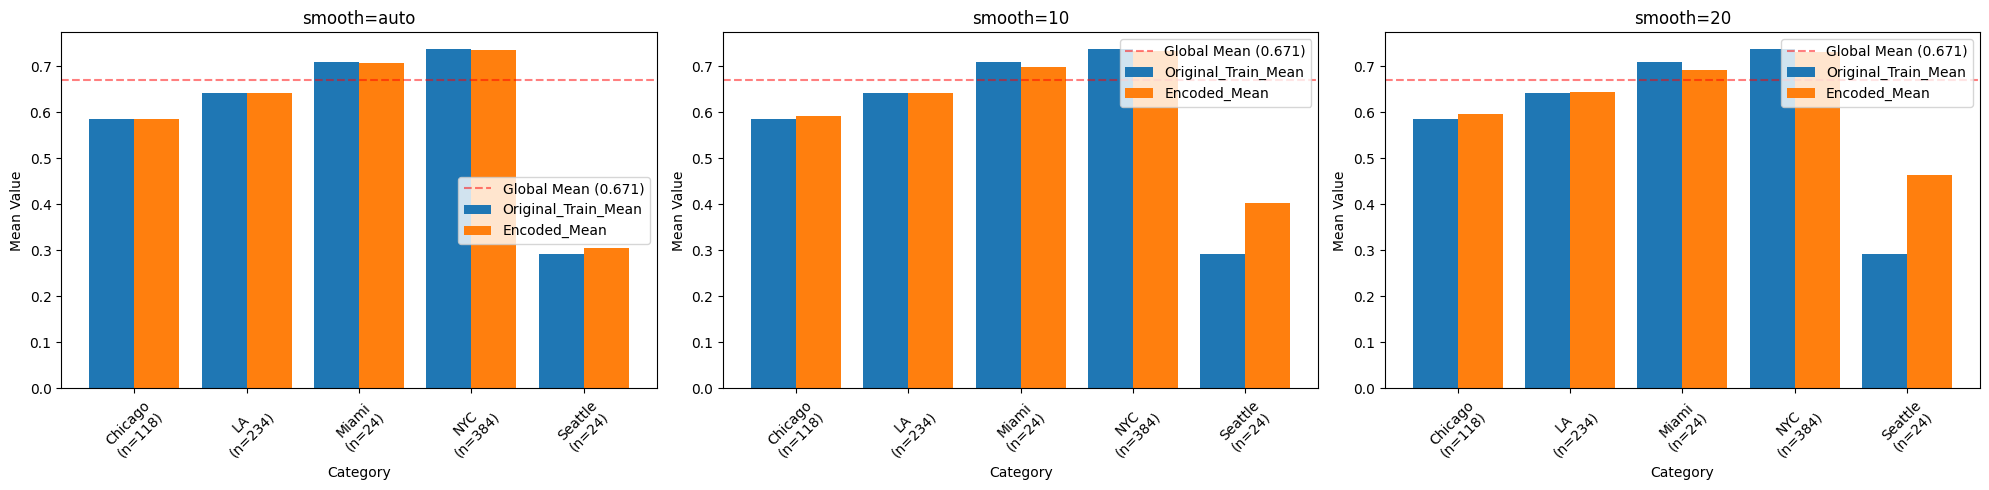

In [17]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

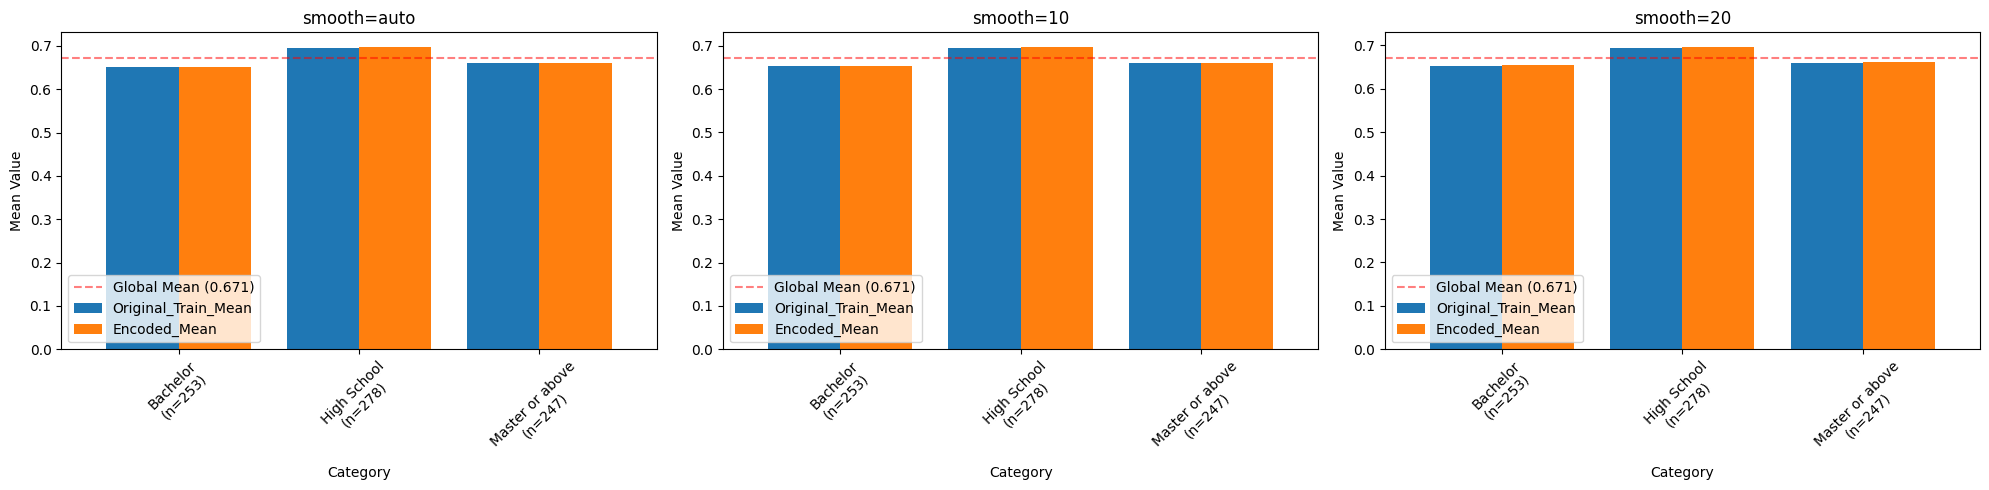

In [18]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'education',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))